In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# **Load the training data**

We load the training data.

In [3]:
import datetime
from implementations import *

data_load = load_data("x_train.csv")
pred = load_data("y_train.csv")
print(f"The data has {data_load.shape[0]} samples and {data_load.shape[1]} features !")

The data has 328135 samples and 321 features !


In [4]:
print(data_load.shape)
i = 0
for col in range(data_load.shape[1]):
    i += 1
    print(data_load[:,col].shape)
print(i)


(328135, 321)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(328135,)
(32813

In [5]:
inx_remove = []
print(data_load[:,0])
print(np.isnan(data_load[:,0]))
for col in range(data_load.shape[1]):
    nan_values = np.isnan(data_load[:,col])
    nan_number = np.count_nonzero(nan_values)

    if nan_number>len(data_load[:,col])*0.8:
        inx_remove.append(col)


print("HHHHHHh")
keep_columns = np.ones(data_load.shape[1], dtype=bool)  # Initialize with True for all columns
keep_columns[inx_remove] = False  # Set False for columns to be removed

# Use the boolean mask to select the columns to keep
data_load_rem = data_load[:, keep_columns]
print(data_load_rem.shape)
print(inx_remove)

[53. 33. 20. ... 39. 33. 32.]
[False False False ... False False False]
HHHHHHh
(328135, 205)
[11, 14, 22, 41, 49, 55, 64, 74, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 224, 225, 226]


In [60]:
for col in range(319):
    
    data_load[:, col][(data_load[:, col] == 7) |(data_load[:, col] == 9) |(data_load[:, col] == 98)|(data_load[:, col] == 99)|(data_load[:, col] == 88)|(data_load[:, col] == 777)|(data_load[:, col] == 888)|(data_load[:, col] == 999) ] = np.nan
    #data_load[:, col][(data_load[:, col] in [7,9,99,88,98]) ] = np.nan
    


    data_load[:, col][(data_load[:, col] == 7) |(data_load[:, col] == 9) ] = np.nan

We clean the data by removing the nan values by the mean of the rest of the feature

In [6]:
data = np.ones(data_load.shape)
stds = np.array([])
for i in range(data.shape[1]):
    d, std = standardize_clean(data_load[:, i])
    data[:, i] = d
    stds = np.append(stds, std)
print(stds.shape)

(321,)


In [7]:
#COLUMNS TO KEEP FROM 120 TO 240
list_to_keep = [122,]

We further clean the data by removing the features where the variance is zero since they are constants for all samples

In [8]:
indices = np.where(stds != 0)
data_var = data[:, indices]
data_var = np.squeeze(data_var, axis = 1)
print(data_var.shape)

(328135, 315)


We also remove the 8 first features as the appear weird in the task of predicting a heart attack

In [9]:
data_cleaned = data_var[:, 9:]
print(data_cleaned.shape)

(328135, 306)


We then separe the data to train on 60% of the total and to test it on the remaining 40% 

In [10]:
train_size = np.floor(data_cleaned.shape[0] * 0.6).astype(int)
data_cross = data_cleaned[:train_size, :]
pred_cross = pred[:train_size]
data_test = data_cleaned[train_size:, :]
pred_test = pred[train_size:]
print(f"Cross shape : {data_cross.shape} ; Test shape : {data_test.shape}")

Cross shape : (196881, 306) ; Test shape : (131254, 306)


Now we build our models for linear regression

In [11]:
y, tx = build_model_data(data_cross, pred_cross)
y_test, tx_test = build_model_data(data_test, pred_test)
print(f"The data has now {tx.shape[1]} features !")

The data has now 307 features !


## Linear regression using gradient descent

Here we train our model using GD with MSE

In [12]:
initial_w = np.zeros(tx.shape[1])
max_iters = 100
gamma = 0.09

start_time = datetime.datetime.now()
w, loss = mean_squared_error_gd(y, tx, initial_w, max_iters, gamma)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

Execution time 13.71139 seconds


# Logistic gradient descent

In [13]:
start_time = datetime.datetime.now()
w =[]
loss = []
for i in range(1,300,10) : 

    w_i, loss_i = logistic_gradient_descent(y, tx, initial_w, gamma=i*0.01,max_iters=max_iters)
    w.append(w_i)
    loss.append(loss_i)

end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")


Execution time 314.557426 seconds


15
1.5565517241379307
0.22385843049294504
[0.5393227375053765, 0.2651330349688938, 0.23970466774515647, 0.23218897621108142, 0.22891739059153665, 0.22718491527572243, 0.22614900477043723, 0.2254753049680671, 0.22501452897210197, 0.2246855371822881, 0.22444266722394618, 0.22425830787629442, 0.22411485630959488, 0.22400023777330139, 0.22390661517044602, 0.22385843049294504, 0.2246576447523296, 0.22562916767233474, 0.22659438087867192, 0.22767366265334496, 0.22902348049576796, 0.23086228858109206, 0.23346757463226078, 0.23684750720472822, 0.24244465269376517, 0.24985536924292015, 0.25863550932795554, 0.26831615429418787, 0.27823233052326535, 0.28626895663807456]


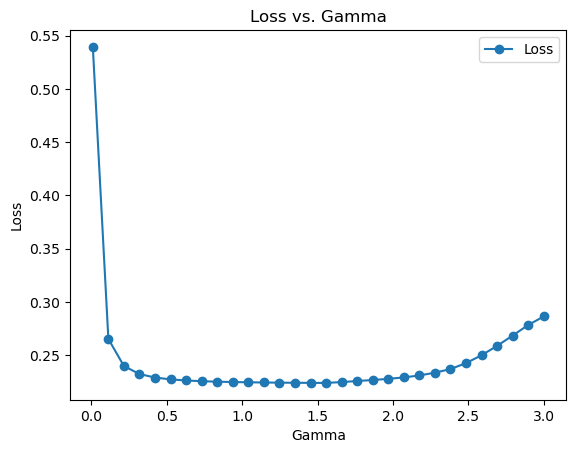

In [14]:
gamma = np.linspace(1, 300, 30)  # Example: gamma values ranging from 0 to 1
gamma = gamma*0.01

plt.plot(gamma, loss, label='Loss', marker='o', linestyle='-')
min_ind = np.argmin(loss)

print(min_ind)
min_gamma = gamma[min_ind]
print(min_gamma)


print(min(loss))
print(loss)
# Add labels and title
plt.xlabel('Gamma')
plt.ylabel('Loss')
plt.title('Loss vs. Gamma')

# Add a legend
plt.legend()

# Show the plot (if you're using a Jupyter Notebook, this step may be optional)
plt.show()

In [70]:
print(len(w))

10


### Computation of metrics

We first compute some metrics on the training data (60% of the total data)

In [108]:
pred_data = np.dot(tx, w[9])
pred_data = (pred_data > 0.49).astype(float)
correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == 0))

tn = np.sum((pred_data == 0) & (y == 0))
fn = np.sum((pred_data == 0) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"True positive rate: {tp/(tp + fp)*100}%")
print(f"True negative rate: {tn/(tn + fn)*100}%")
print(w)

Accuracy: 91.39480193619495%
True positive rate: 64.76683937823834%
True negative rate: 91.52596010535127%
[-3.11371141e+00  4.71795946e-03 -1.27247436e-02  1.03528382e-04
  2.59156684e-02  1.98935402e-02  1.87042232e-02 -1.65913184e-02
 -1.77390389e-02  1.50631698e-02  8.06958212e-03  5.55694233e-03
  4.56046533e-01 -7.45809306e-02 -8.71161286e-03 -1.01731123e-02
 -2.37825476e-02  2.79677423e-02 -3.34968590e-02 -9.36073875e-03
 -1.82125607e-01 -7.78571215e-02 -6.68445230e-02 -1.01104798e-01
 -2.31637925e-01 -1.38079099e-01 -2.98209764e-02  3.12323887e-03
 -2.21179762e-02 -2.41276663e-04 -5.20550780e-02  1.64300770e-02
 -1.33293778e-02 -4.53091551e-02 -9.39733028e-02 -6.72943220e-02
 -3.28919132e-01 -4.12541568e-02 -1.55293445e-02  1.82542997e-02
  9.63204951e-03  2.62259635e-03  9.63329571e-04 -4.82799100e-02
  1.30691901e-01 -5.14186632e-03  2.48040211e-02  3.56841876e-02
 -3.18031822e-02  2.45015032e-02  1.30618403e-02 -3.39852302e-02
 -3.85933966e-02 -2.47108391e-02 -1.36636182e-03

Now we compute some metrics for our test data (40% of the total data)

In [107]:
pred_test = np.dot(tx_test, w[9])
pred_test = (pred_test > 0.49).astype(float)
correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == 0))

tn = np.sum((pred_test == 0) & (y_test == 0))
fn = np.sum((pred_test == 0) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"True positive rate: {tp/(tp + fp)*100}%")
print(f"True negative rate: {tn/(tn + fn)*100}%")

Accuracy: 91.20560135310161%
True positive rate: 66.24405705229795%
True negative rate: 91.32618298461986%


In [75]:
#filter removing small weights
#selecting the weights
w = w[9]
indices_to_keep = np.where(np.abs(w) > 0.01)[0]
weights_filtered = w[indices_to_keep]

#removing columns with small weights
data_cross_2 = data_cross[:,indices_to_keep]

#Build model again
y, tx = build_model_data(data_cross_2, pred_cross)
data_test_2 = data_test[:,indices_to_keep]
y_test, tx_test = build_model_data(data_test_2, pred_test)
print(f"The data has now {tx.shape[1]} features !")

#retest log
initial_w = np.zeros(tx.shape[1])
start_time = datetime.datetime.now()
w, loss = logistic_gradient_descent(y, tx, initial_w, gamma=0.9,max_iters=max_iters)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")

#Metrics
pred_test = np.dot(tx_test, w)
pred_test = (pred_test > 0.49).astype(float)
correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == 0))

tn = np.sum((pred_test == 0) & (y_test == 0))
fn = np.sum((pred_test == 0) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"True positive rate: {tp/(tp + fp)*100}%")
print(f"True negative rate: {tn/(tn + fn)*100}%")

The data has now 155 features !
Execution time 5.903289 seconds
Accuracy: 99.64877260883478%
True positive rate: 84.32835820895522%
True negative rate: 99.79084645669292%


In [105]:
from implementations import regd_logistic_regression
start_time = datetime.datetime.now()
w = regd_logistic_regression(tx, y,lr=1,max_iter=100,fit_intercept=False)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds")


Execution time 11.876921 seconds


### Feature analysis

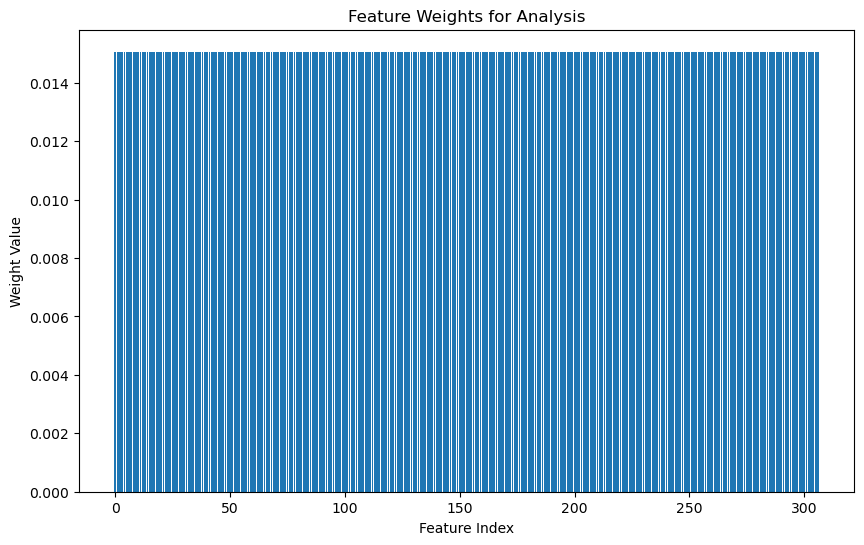

In [106]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(w)), np.abs(w[9]))
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()

In [78]:
print(np.var(w))

print(w)

0.06497531297318257
[-3.09980706e+00  2.05106101e-04 -1.38024534e-03 -1.28033571e-02
  1.37341845e-02  3.63259759e-03  3.09715253e-01 -1.42121724e-02
  6.13988863e-03 -3.46628196e-02  5.65437098e-02 -5.85798682e-02
  3.10908140e-03 -7.49976140e-02 -8.04153268e-02 -1.28557335e-01
 -1.33603748e-01 -1.79693958e-01 -1.09348516e-02 -2.42311961e-02
  6.77829300e-03 -1.33432853e-01 -3.88550747e-02 -3.85608626e-02
 -7.38499757e-02 -7.83893520e-02 -3.40740573e-02 -3.17968639e-01
 -2.84704640e-02 -2.55780151e-02 -2.29428461e-02  1.30583738e-03
 -3.68137833e-02  8.33918315e-02 -6.08462771e-03 -3.59192991e-02
  1.60529810e-02 -2.00636786e-03 -3.84919001e-02 -3.60657614e-02
 -1.19539824e-02  2.02547071e-02 -1.98687370e-02 -9.07958496e-02
  3.29882636e-02 -3.21715614e-02 -1.76257404e-03  8.46985490e-03
  4.44060679e-02 -2.21591791e-03  2.42573568e-02 -1.40226900e-02
 -1.93361310e-02 -1.82557168e-02  4.99305536e-04  6.81237858e-03
  1.10782513e-02 -8.97458976e-03  2.97209694e-02  6.92731513e-03
 -1.6

# **Load the testing data**

In [17]:
test_data, test_pred, test_ids = load_data("test.csv")
for i in range(test_data.shape[1]):
    test_data[:, i] = standardize(test_data[:, i])[0]
test_y, test_tx = build_model_data(test_data, test_pred)

FileNotFoundError: ../data/test.csv not found.

### Predict the label with our trained model

In [112]:
test_y = np.dot(test_tx, w)
test_y = (test_y > 0.5).astype(float)